In [17]:
using Revise
using QuanticsTCI
using SparseIR
import SparseIR: valueim
using ITensors
import TensorCrossInterpolation as TCI
using LinearAlgebra
import MSSTA
using PyPlot
using PyCall
using JLD2
using FileIO
ITensors.disable_warn_order()

In [18]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

In [19]:
prefix = "fancy"

"fancy"

In [20]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

function genfunc(beta)
    v = FermionicFreq(1)
    iv = valueim(v, beta)
    gk(kx, ky) = 1 / (iv - ek(kx, ky))
    v = FermionicFreq(1)
    iv = valueim(v, beta)
    function gkb(b)
        nbit = length(b) ÷ 2
        N = 2^nbit
        ikx = frombins(b[1:2:end])
        iky = frombins(b[2:2:end])
        @assert ikx ≤ N
        @assert iky ≤ N
        kx = 2π * (ikx - 1)/N
        ky = 2π * (iky - 1)/N
        return abs.(gk(kx, ky))
    end
    return gkb
end    

function gengkdata(gkb, nbit)
    N = 2^nbit
    gkdata = zeros(Float64, N, N)
    for ikx in 1:N, iky in 1:N
        bx = tobins(ikx, nbit)
        by = tobins(iky, nbit)
        b = collect(Iterators.flatten(zip(bx, by)))
        gkdata[ikx, iky] = gkb(b)
    end
    return gkdata
end

gengkdata (generic function with 1 method)

In [21]:
ek(kx, ky) = 2*cos(kx) + 2*cos(ky) + cos(2*kx) + cos(4*ky) - 1.0

ek (generic function with 1 method)

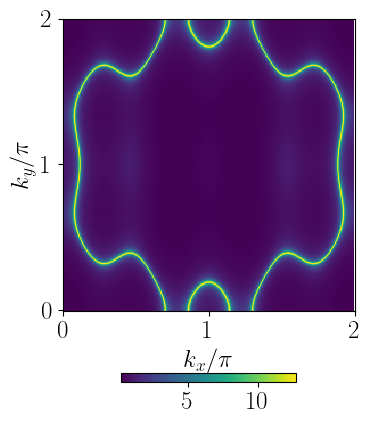

In [22]:
gkdata = gengkdata(genfunc(40.0), 8)

x = LinRange(0.0, 2.0, size(gkdata, 1)+1)[1:end-1]

plt[:pcolormesh](x, x, abs.(gkdata), rasterized=true)
ax = plt.gca().set_aspect("equal")
xlabel(L"k_x/\pi")
ylabel(L"k_y/\pi")
xticks([0, 1, 2])
yticks([0, 1, 2])
colorbar(shrink=0.3, location="bottom")

tight_layout()
savefig(prefix * "_gk.pdf", bbox_inches="tight", transparent=true)

display(gcf())
close(gcf())

In [29]:
betas = [1.0, 4.0, 16.0, 64.0, 128.0]
tols = [1e-5]
nbits = [12, 16, 20]

3-element Vector{Int64}:
 12
 16
 20

In [30]:
sites_nbit = Dict()
for nbit in nbits
    sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
    sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
    sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
    sites_nbit[nbit] = sites
end

## QTCI

In [31]:
maxiter = 10000
BLAS.set_num_threads(16)

qtts = Dict()
qtt_ranks = Dict()

for tol in tols
    for beta in betas
        for nbit in nbits
            @show tol, beta, nbit
            bx_ = tobins(1, nbit)
            by_ = tobins(2^(nbit-1), nbit)
            func = genfunc(beta)
            firstpivot = TCI.optfirstpivot(func, fill(2, 2*nbit))
            qtt, ranks, errors = TCI.crossinterpolate(
                ComplexF64, func, fill(2, 2*nbit),
                firstpivot, tolerance=tol, maxiter=maxiter, verbosity=1,
                #pivottolerance=tol
            )
            qtts[(beta,nbit,tol)] = qtt
            qtt_ranks[(beta,nbit,tol)] = ranks
        end
    end
end

(tol, beta, nbit) = (1.0e-5, 1.0, 12)
rank= 10 , error= 0.17947647947316972
rank= 20 , error= 0.016636828779931768
rank= 30 , error= 0.0024801884338378397
rank= 40 , error= 0.00019637746799017864
rank= 50 , error= 4.9571575456763015e-5
(tol, beta, nbit) = (1.0e-5, 1.0, 16)
rank= 10 , error= 0.17948931850788846
rank= 20 , error= 0.016622273961788957
rank= 30 , error= 0.0025183179975938625
rank= 40 , error= 0.0002159764919745042
rank= 50 , error= 4.686298016351749e-5
(tol, beta, nbit) = (1.0e-5, 1.0, 20)
rank= 10 , error= 0.17947791512221223
rank= 20 , error= 0.016624021483310047
rank= 30 , error= 0.0025183965949131786
rank= 40 , error= 0.00021608221866485544
rank= 50 , error= 4.6917277142559795e-5
(tol, beta, nbit) = (1.0e-5, 4.0, 12)
rank= 10 , error= 0.6038104363034681
rank= 20 , error= 0.19601162669998765
rank= 30 , error= 0.05660153786797153
rank= 40 , error= 0.02345782608663396
rank= 50 , error= 0.005432198617988686
rank= 60 , error= 0.0015582659895032123
rank= 70 , error= 0.000443

In [32]:
countnelem(M::MPS) = sum([prod(size(M[n])) for n in 1:length(M)])

countnelem (generic function with 1 method)

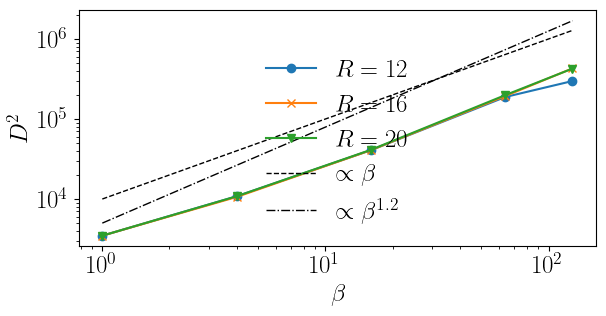

In [33]:
fig = figure(figsize=(6.4, 3.5))

tol = tols[end]

markers = ["o", "x", "v"]

for (i, nbit) in enumerate(nbits)
    ranks = [TCI.rank(qtts[(beta,nbit,tol)]) for beta in betas]
    loglog(betas, ranks .^ 2, marker=markers[i], label=L"R=%$(nbit)")
end

loglog(betas, 1e+4 * betas, label=L"\propto \beta", ls="--", color="k", lw=1.0)
loglog(betas, 5e+3 * betas .^ 1.2, label=L"\propto \beta^{1.2}", ls="-.", color="k", lw=1.0)
#loglog(betas, 1e+4 * betas .^ 0.5, label=L"\propto \beta^{1/2}", ls="-.", color="k", lw=1.0)

xlabel(L"\beta")
ylabel(L"D^2")
#xlim([0, 250])
#ylim([1e-7, 1e-1])
legend(frameon=false)

tight_layout()
#savefig(prefix * "_gk_rank_scaling_tol$(tol).pdf", bbox_inches="tight", transparent=true, rasterized=true)
#savefig("dyson3.pdf", bbox_inches="tight", transparent=true, rasterized=true)

display(gcf())
close(gcf())
    

In [34]:
tmp = Dict()
tmp["params"] = collect(keys(qtts))
for (beta, R, tol) in keys(qtts)
    tmp["$(beta) $(R) $(tol)"] = qtts[(beta, R, tol)]
end
save(prefix * "_gk_rank_scaling_tol$(tol).jld2", tmp)